In [1]:
import os
import time
import shutil
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from keras.models import Model,Sequential
from matplotlib.pyplot import imshow
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import (Conv2D, 
                          GlobalAveragePooling2D,
                          Dropout, Flatten, Dense, 
                          Activation,GlobalMaxPooling2D)
from tensorflow.keras.optimizers.legacy import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.applications.inception_v3 import InceptionV3
from sklearn.model_selection import train_test_split
from IPython.display import display, HTML
from sklearn.metrics import confusion_matrix, classification_report
sns.set_style('darkgrid')
from PIL import Image
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [24]:
print(tf.__version__)

2.11.0


### Load Base Model

In [25]:
TRAIN_PATH = r'./fruits/dataset/train/'
TEST_PATH = r'./fruits/dataset/test/'
BATCH_SIZE = 32
EPOCHS = 10
learning_rate = 0.001
IMG_SHAPE = (224,224) # (224,224)

# Train generator 
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                 zoom_range=0.2,
                                 shear_range=0.3,
                                 horizontal_flip=True,
                                 brightness_range=[0.5,1.5])

# Test generator 
test_datagen = ImageDataGenerator(rescale=1/255.0)


# Generate data from train and test directories 
train_gen = train_datagen.flow_from_directory(TRAIN_PATH,
                                            target_size=IMG_SHAPE,
                                            batch_size=BATCH_SIZE,
                                            class_mode="binary") # binary
# Generate data from test directories 
test_gen = test_datagen.flow_from_directory(TEST_PATH,
                                            target_size=IMG_SHAPE,
                                            batch_size=BATCH_SIZE,
                                            class_mode="binary")



Found 8949 images belonging to 8 classes.
Found 8949 images belonging to 8 classes.


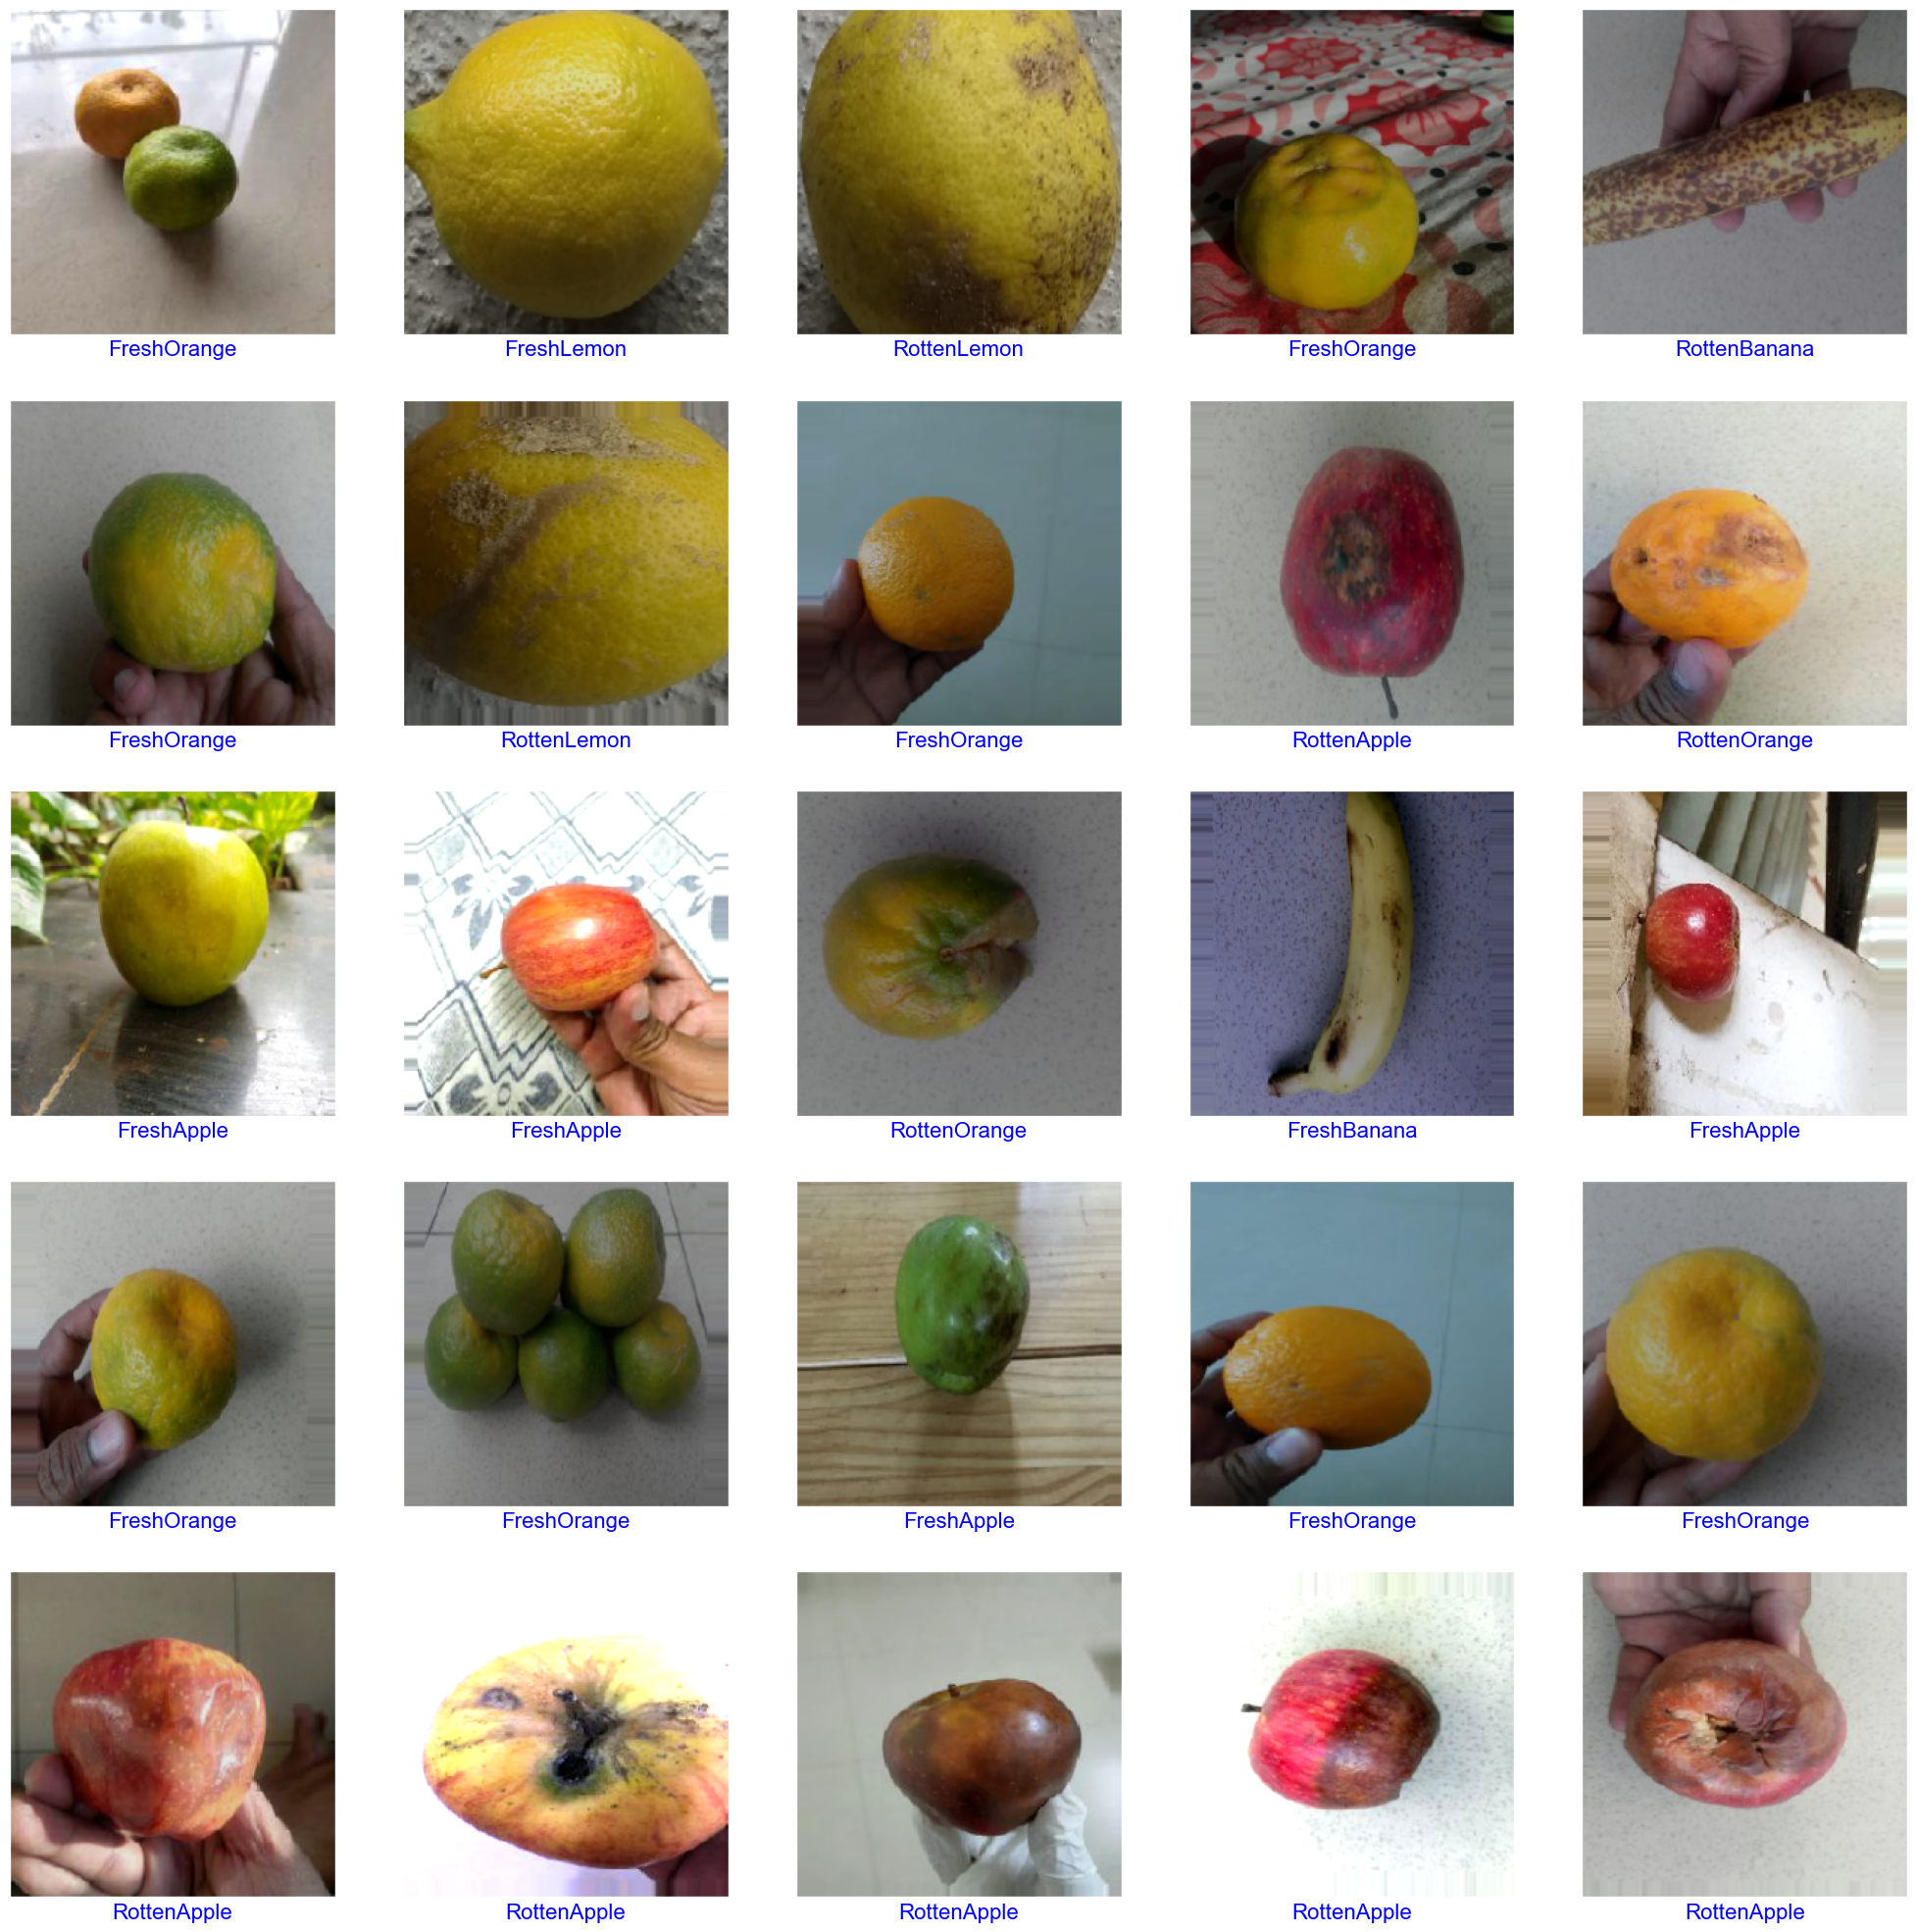

In [26]:
# Get classes dict 
classes_dict = dict(test_gen.class_indices)

# Reverse 
classes_dict = {v: k for k,v in classes_dict.items()}

# Let's plot sone images 
images,labels=train_gen.next()
plt.figure(figsize=(25,25))
for i in range(25):
    plt.subplot(5,5,i+1)
    image=(images[i]+1 )/2
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(classes_dict[labels[i]], color="blue",fontsize=16)

In [27]:
# Create Inception Model 
inception = InceptionV3(weights='imagenet',input_shape=(224, 224, 3),include_top=False) # 224, 224

# Show the base model summary 
# inception.summary()

# Show how manay layers in the Resnet Network
layers = inception.layers
print(f'Number of Layers: {len(layers)}')

Number of Layers: 311


In [28]:
# Number of samples for each set 
TRAIN_SIZE = train_gen.samples
TEST_SIZE = test_gen.samples

# Early stopping 
callbacks = EarlyStopping(patience = 3, monitor='val_accuracy')
                        
# Let's train our Model 
inputs = inception.input

# Get the output of inception NN and add an average pooling layer
x = inception.output
x = GlobalAveragePooling2D()(x)

# Add the a dense layer
x = Dense(512, activation='relu')(x)

# Add a dropout 
x = Dropout(0.5)(x)

# Finally, add an output layer
outputs = Dense(16, activation ='softmax')(x)

# Build the model to train 
model = Model(inputs=inputs, outputs=outputs)

# Freeze all convolutional inception layers
for layer in layers:
    layer.trainable = False
    
# Compile the model 
model.compile(optimizer=Adam(lr=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model for 10 epochs 
history = model.fit_generator(
                train_gen,
                epochs= EPOCHS,
                validation_data = test_gen,
                validation_steps = TEST_SIZE//BATCH_SIZE,
                steps_per_epoch = TRAIN_SIZE//BATCH_SIZE,
                callbacks = [callbacks])

Epoch 1/10


2022-12-29 22:44:37.878994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


279/279 [==============================] - ETA: 0s - loss: 0.3697 - accuracy: 0.8754

2022-12-29 22:45:38.713003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


279/279 [==============================] - 88s 309ms/step - loss: 0.3697 - accuracy: 0.8754 - val_loss: 0.1283 - val_accuracy: 0.9571
Epoch 2/10
279/279 [==============================] - 85s 303ms/step - loss: 0.1726 - accuracy: 0.9412 - val_loss: 0.0968 - val_accuracy: 0.9680
Epoch 3/10
279/279 [==============================] - 86s 308ms/step - loss: 0.1357 - accuracy: 0.9508 - val_loss: 0.0863 - val_accuracy: 0.9693
Epoch 4/10
279/279 [==============================] - 83s 299ms/step - loss: 0.1175 - accuracy: 0.9584 - val_loss: 0.0547 - val_accuracy: 0.9806
Epoch 5/10
279/279 [==============================] - 86s 308ms/step - loss: 0.1031 - accuracy: 0.9640 - val_loss: 0.0548 - val_accuracy: 0.9810
Epoch 6/10
279/279 [==============================] - 88s 314ms/step - loss: 0.1040 - accuracy: 0.9642 - val_loss: 0.0491 - val_accuracy: 0.9826
Epoch 7/10
279/279 [==============================] - 87s 311ms/step - loss: 0.0888 - accuracy: 0.9689 - val_loss: 0.0505 - val_accuracy: 0.9

Text(0.5, 0, 'Epochs')

<Figure size 640x480 with 0 Axes>

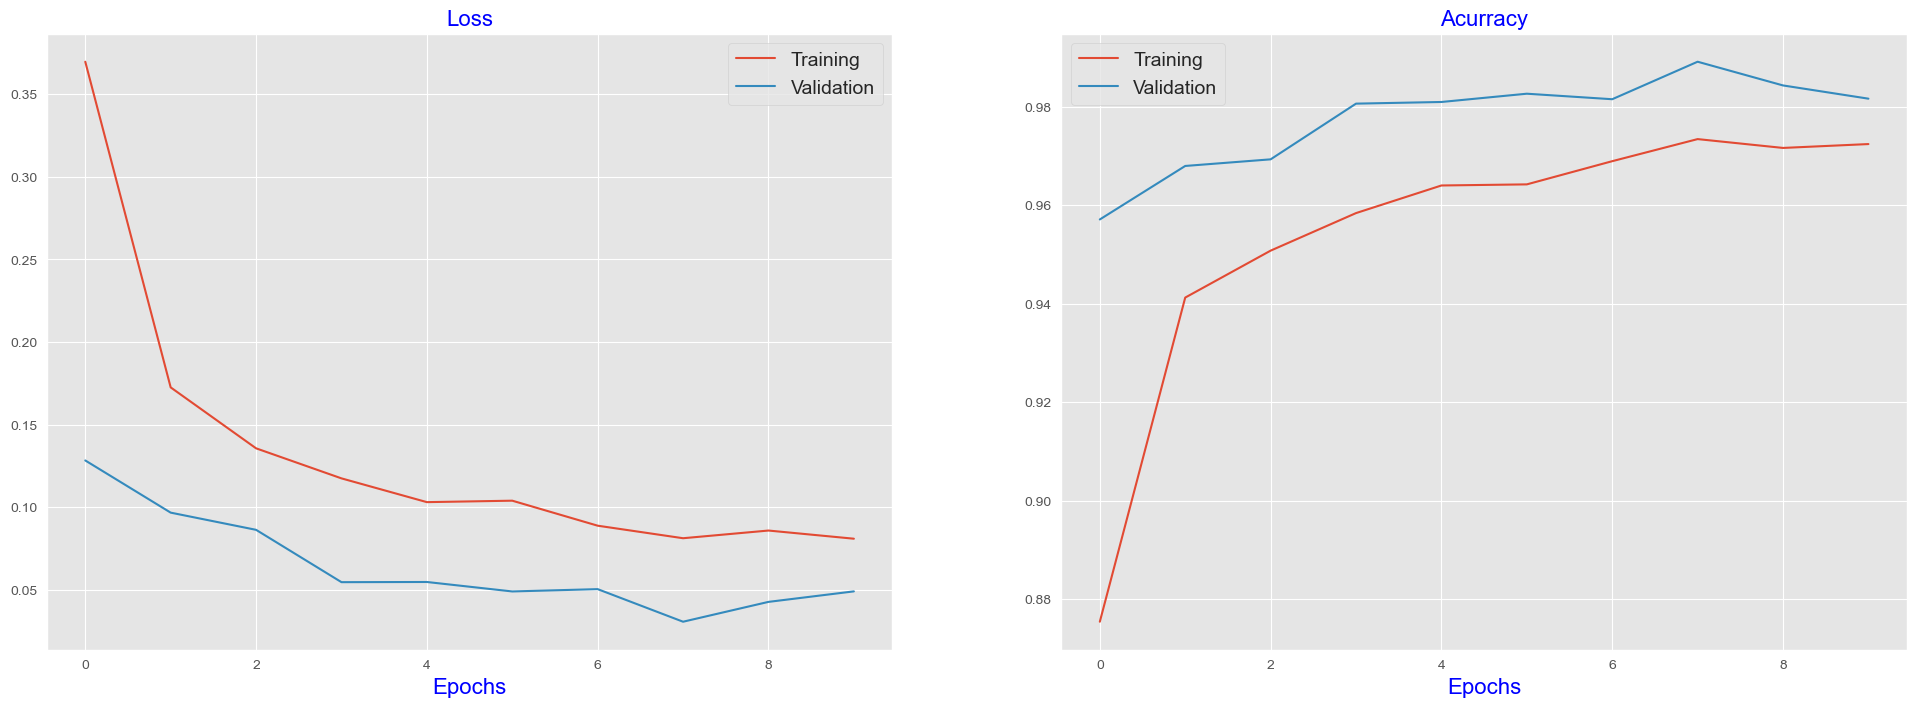

In [29]:
# Plot training loss vs validation loss
plt.style.use('ggplot')
plt.figure()
fig,(ax1, ax2)=plt.subplots(1,2,figsize=(24,8)) # 19,8
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['Training','Validation'], fontsize=14)
ax1.set_title('Loss', color="blue",fontsize=16)
ax1.set_xlabel('Epochs', color="blue",fontsize=16)

# Plot training accuracy vs validation accuracy 
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['Training','Validation'],fontsize=14)
ax2.set_title('Acurracy', color="blue",fontsize=16)
ax2.set_xlabel('Epochs', color="blue",fontsize=16)

In [36]:
# Evaluate
loss, test_acc = model.evaluate(test_gen)
print(f"Validation Accuracy = {test_acc :.3f}  \nValidation Loss = {loss :.3f}" )

280/280 [==============================] - 26s 92ms/step - loss: 0.0490 - accuracy: 0.9817
Validation Accuracy = 0.982  
Validation Loss = 0.049


280/280 [==============================] - 25s 89ms/step


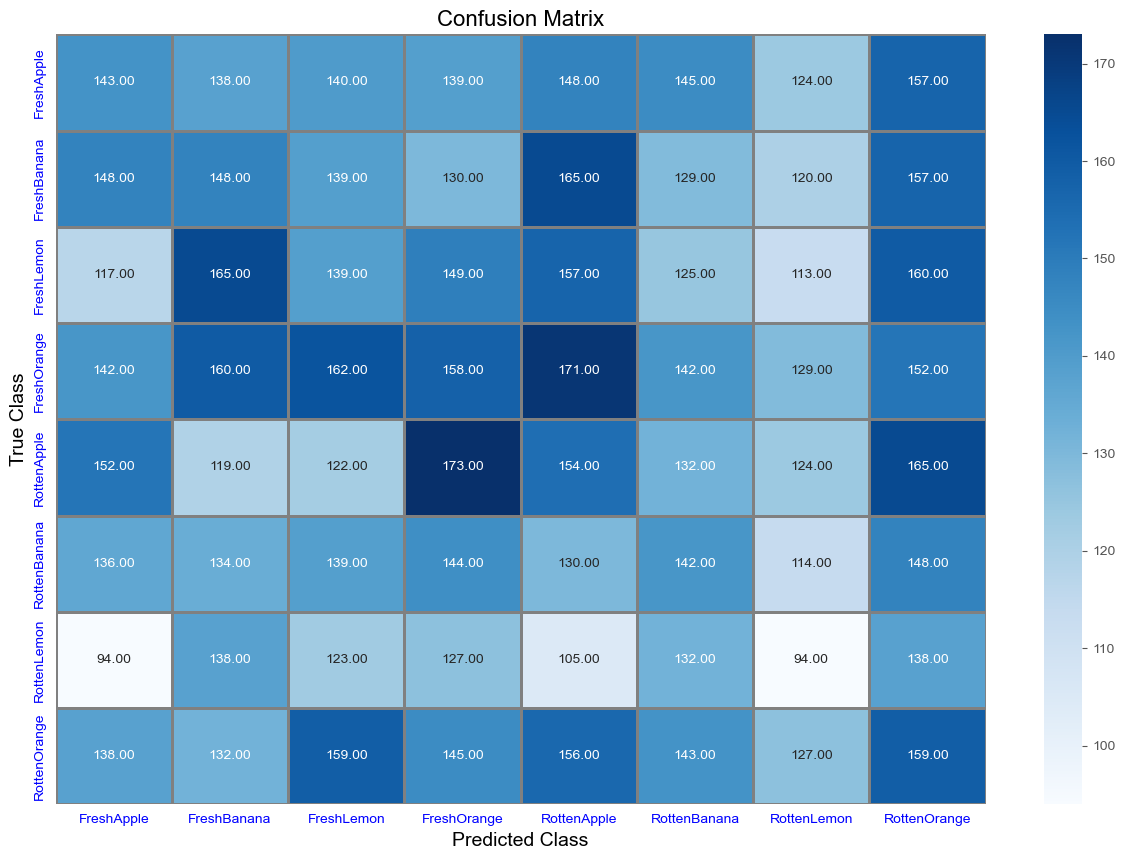

In [39]:
class_names = list(classes_dict.values())
labels = test_gen.classes
preds =  model.predict(test_gen)
predictions = np.argmax(preds, axis=1)

# Show the confusion matrix 
conf_matrix = confusion_matrix(labels, predictions) 

# Plot the confusion matrix
fig,ax = plt.subplots(figsize=(15, 10))
sns.heatmap(conf_matrix,annot=True,linewidths=2,cmap="Blues", linecolor="gray",fmt='.2f',ax=ax)
plt.xlabel("Predicted Class", color="black",fontsize=14)
plt.ylabel("True Class",color="black",fontsize=14)
plt.title("Confusion Matrix", color="black",fontsize=16)
ax.set_xticklabels(labels = class_names,fontdict=None, color="blue",fontsize=10)
ax.set_yticklabels(labels = class_names,fontdict=None, color="blue",fontsize=10)
plt.show()


2022-12-29 23:11:12.507661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 31ms/step


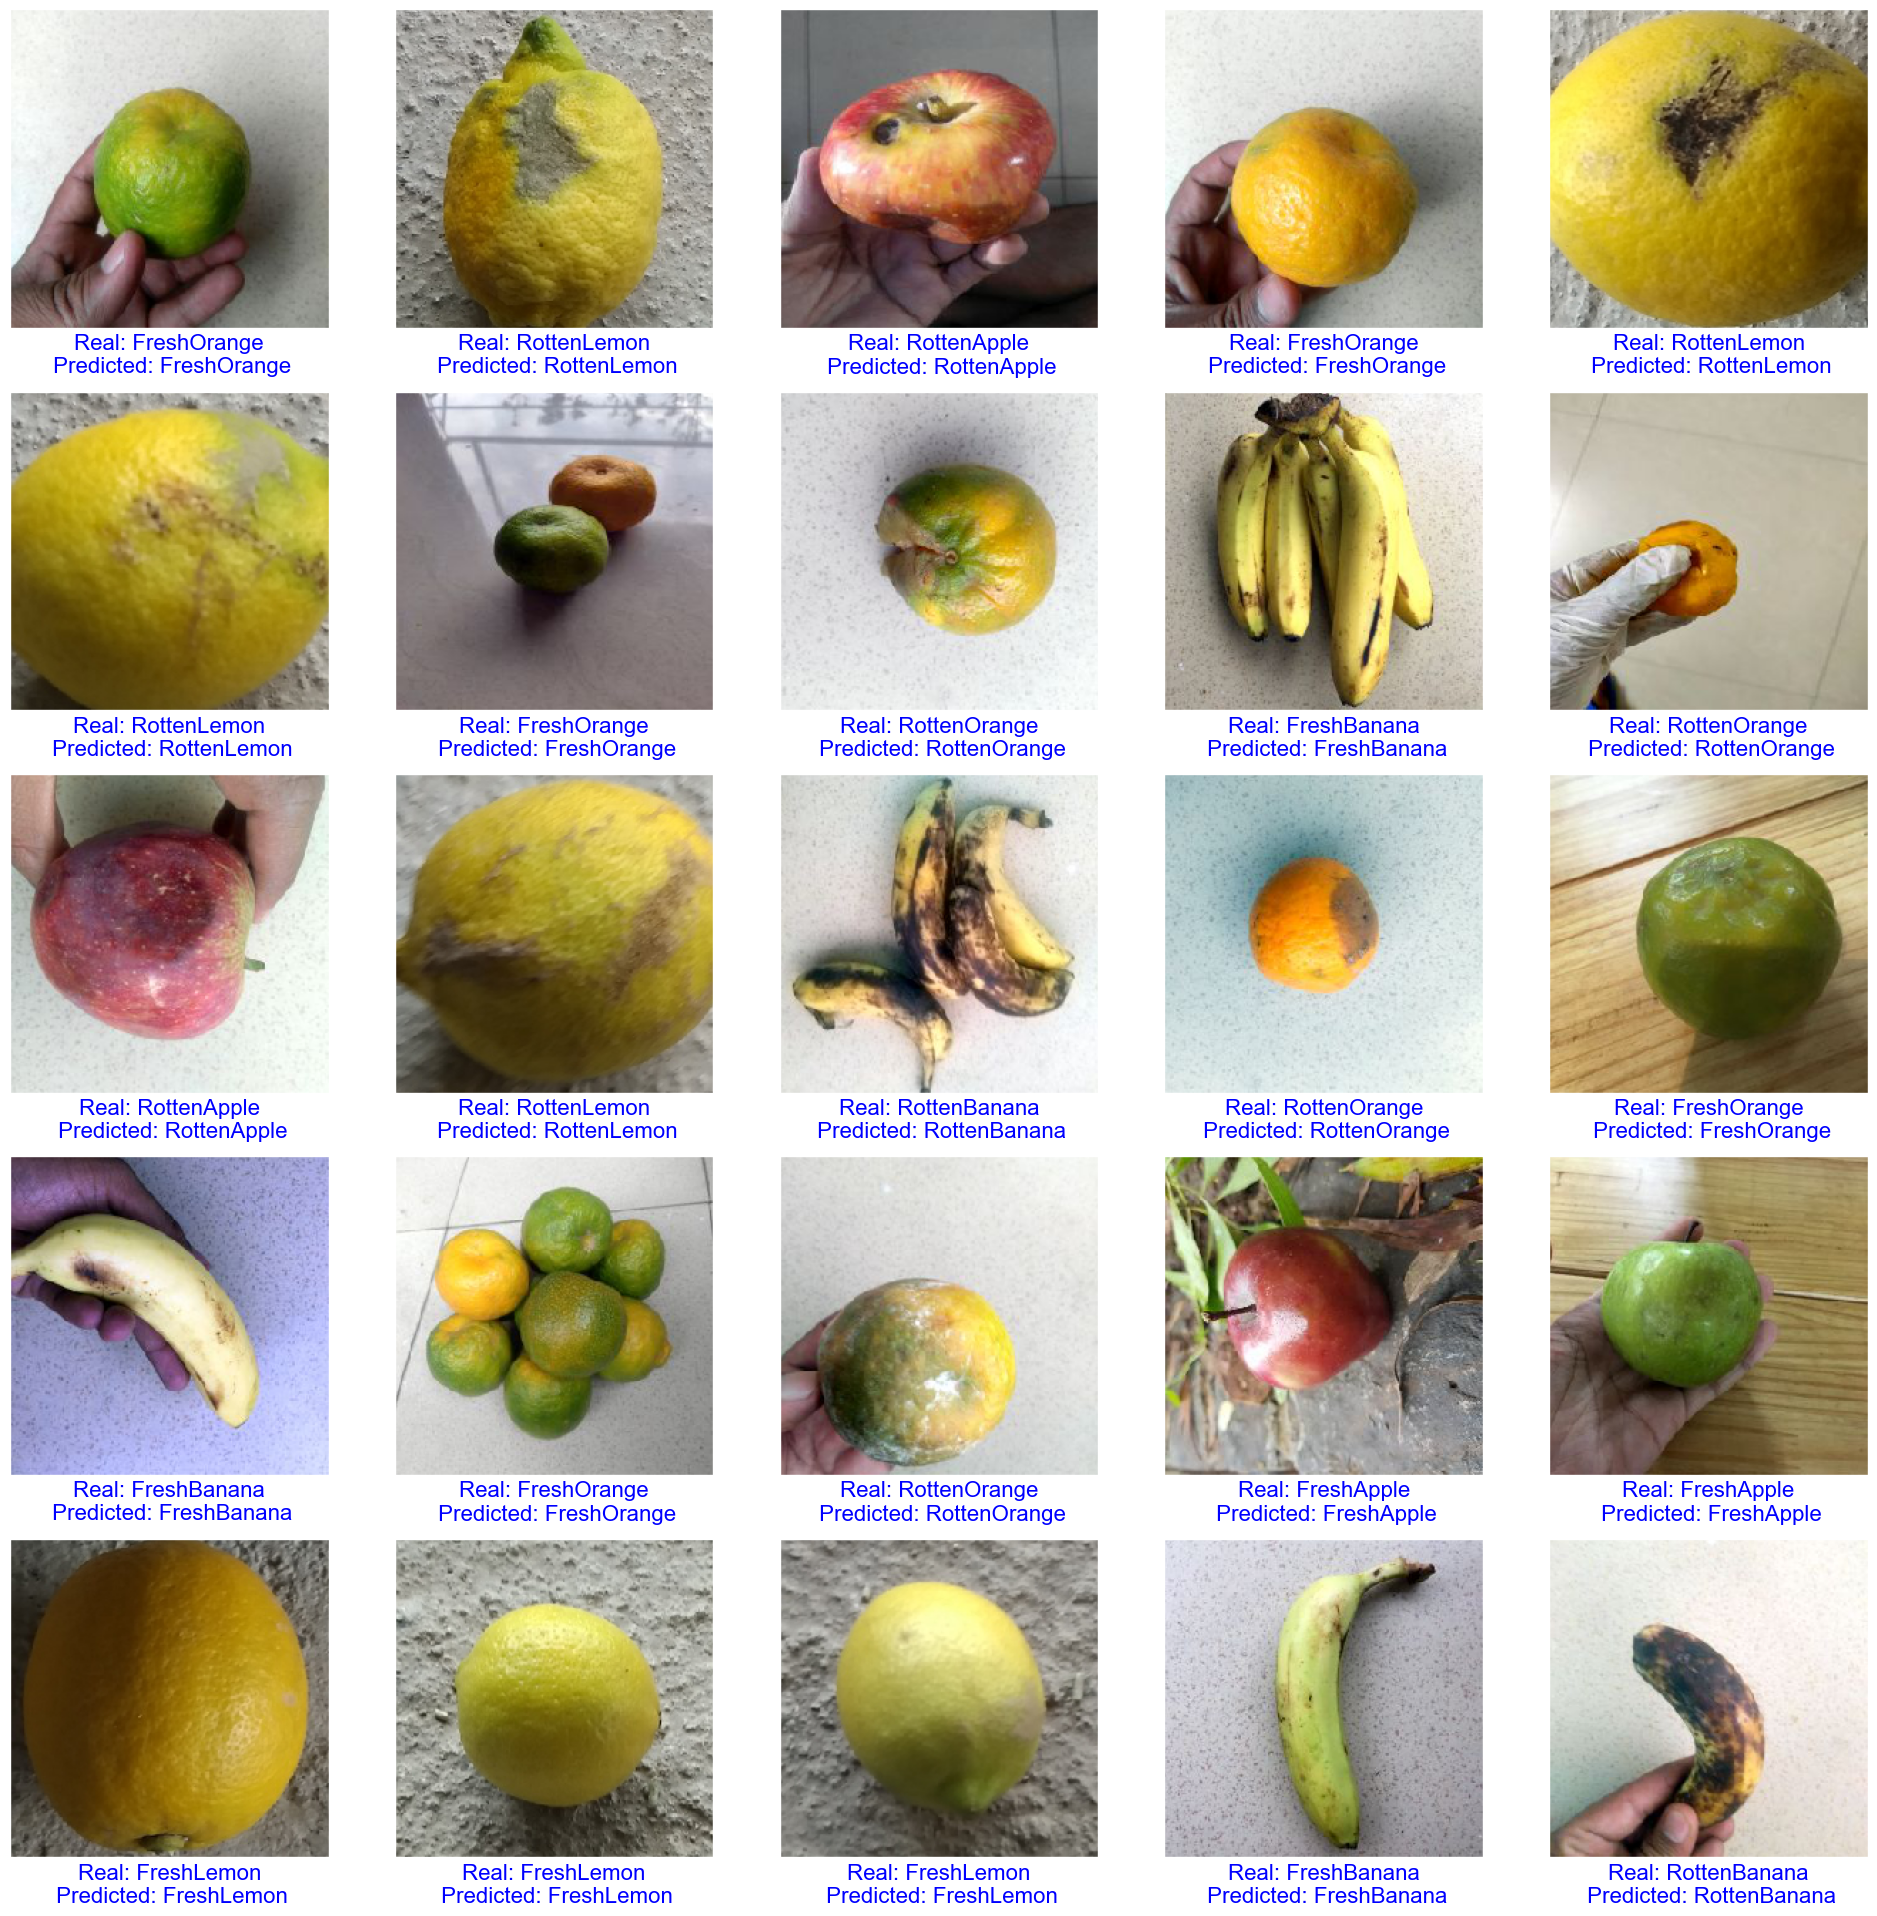

In [40]:
test_images,test_labels=test_gen.next()
plt.figure(figsize=(24,24)) # 25,15
for i in range(25):
    plt.subplot(5,5,i+1)
    image=(images[i] + 1 ) / 2
    plt.imshow(test_images[i])
    plt.xticks([])
    plt.yticks([])
    real = classes_dict[test_labels[i]]
    img = test_images[i].reshape(1,224,224,3) # 224,224
    predicted = int(np.argmax(model.predict(img),axis=1))
    predicted = classes_dict[predicted]
    plt.xlabel(f"Real: {real}\n Predicted: {predicted}", color="blue",fontsize=16)    
